# ECE 491 — Homework 7
**Deep Learning Architectures: LeNet-5 and ResNet-18 on MNIST**

**Student:** Ameen 
**Date:** October 12, 2025  
**Course:** ECE 491 - Introduction to Machine Learning



In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from datetime import datetime

plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Physical devices: {tf.config.list_physical_devices()}")

TensorFlow version: 2.20.0
GPU available: False
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Dataset Loading and Preprocessing

Load the MNIST dataset and prepare it for training. We'll use the built-in Keras dataset loader, but also provide a backup helper function for loading raw IDX files.

In [ ]:

numEpochs = 5  
batchSize = 128
learningRate = 1e-3
validationSplit = 0.1
saveFigures = True  


if saveFigures:
    os.makedirs('figs', exist_ok=True)


tf.random.set_seed(42)
np.random.seed(42)

print(f"Configuration:")
print(f"  Epochs: {numEpochs}")
print(f"  Batch size: {batchSize}")
print(f"  Learning rate: {learningRate}")
print(f"  Validation split: {validationSplit}")
print(f"  Save figures: {saveFigures}")

Configuration:
  Epochs: 5
  Batch size: 128
  Learning rate: 0.001
  Validation split: 0.1
  Save figures: True


In [ ]:
def loadMnistFromIdx(trainImagesPath='train-images-idx3-ubyte', 
                     trainLabelsPath='train-labels-idx1-ubyte',
                     testImagesPath='t10k-images-idx3-ubyte', 
                     testLabelsPath='t10k-labels-idx1-ubyte'):
    """
    Helper function to load MNIST from raw IDX files if Keras download fails.
    Note: Drop the four MNIST IDX files in the working directory if online fetch fails.
    """
    import struct
    
    def readIdx(filename):
        with open(filename, 'rb') as f:
            magic = struct.unpack('>I', f.read(4))[0]
            if magic == 2051:  # images
                numImages = struct.unpack('>I', f.read(4))[0]
                rows = struct.unpack('>I', f.read(4))[0]
                cols = struct.unpack('>I', f.read(4))[0]
                data = np.frombuffer(f.read(), dtype=np.uint8)
                return data.reshape(numImages, rows, cols)
            elif magic == 2049:  # labels
                numLabels = struct.unpack('>I', f.read(4))[0]
                return np.frombuffer(f.read(), dtype=np.uint8)
    
    try:
        trainImages = readIdx(trainImagesPath)
        trainLabels = readIdx(trainLabelsPath)
        testImages = readIdx(testImagesPath)
        testLabels = readIdx(testLabelsPath)
        return (trainImages, trainLabels), (testImages, testLabels)
    except FileNotFoundError:
        print("IDX files not found. Please ensure MNIST IDX files are in the working directory.")
        return None


try:
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    print("Successfully loaded MNIST from Keras datasets")
except:
    print("Keras download failed, attempting to load from IDX files...")
    data = loadMnistFromIdx()
    if data:
        (xTrain, yTrain), (xTest, yTest) = data
        print("Successfully loaded MNIST from IDX files")
    else:
        raise Exception("Could not load MNIST dataset")

print(f"Training set shape: {xTrain.shape}, Labels: {yTrain.shape}")
print(f"Test set shape: {xTest.shape}, Labels: {yTest.shape}")
print(f"Pixel value range: [{xTrain.min()}, {xTrain.max()}]")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Successfully loaded MNIST from Keras datasets
Training set shape: (60000, 28, 28), Labels: (60000,)
Test set shape: (10000, 28, 28), Labels: (10000,)
Pixel value range: [0, 255]


Preprocessed shapes:
  28x28 format: Train (60000, 28, 28, 1), Test (10000, 28, 28, 1)
  32x32 format: Train (60000, 32, 32, 1), Test (10000, 32, 32, 1)


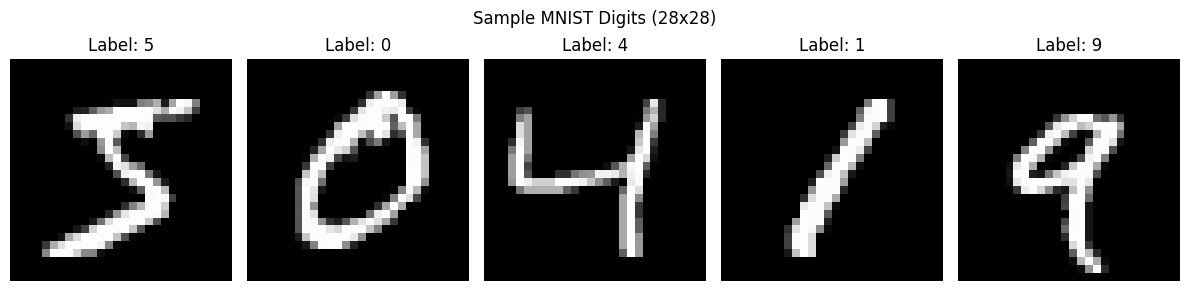

In [ ]:

xTrain = xTrain.astype('float32') / 255.0
xTest = xTest.astype('float32') / 255.0


xTrain = np.expand_dims(xTrain, -1)
xTest = np.expand_dims(xTest, -1)


xTrainPadded = tf.pad(xTrain, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
xTestPadded = tf.pad(xTest, [[0, 0], [2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)

print(f"Preprocessed shapes:")
print(f"  28x28 format: Train {xTrain.shape}, Test {xTest.shape}")
print(f"  32x32 format: Train {xTrainPadded.shape}, Test {xTestPadded.shape}")

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(xTrain[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {yTrain[i]}')
    axes[i].axis('off')
plt.suptitle('Sample MNIST Digits (28x28)')
plt.tight_layout()
if saveFigures:
    plt.savefig('figs/mnist_samples.png', dpi=300, bbox_inches='tight')
plt.show()

## Q1 — LeNet-5 on MNIST (from scratch, Keras)

### Architecture Summary

LeNet-5 is a foundational CNN architecture proposed by Yann LeCun. The architecture follows this structure:
- **Input:** 32×32 grayscale image (padded MNIST)
- **C1:** 6 feature maps, 5×5 kernels → 28×28 output
- **S2:** 2×2 average pooling → 14×14 output  
- **C3:** 16 feature maps, 5×5 kernels → 10×10 output
- **S4:** 2×2 average pooling → 5×5 output
- **Flatten:** Convert to 1D vector (400 features)
- **F5:** Fully connected layer with 120 units
- **F6:** Fully connected layer with 84 units  
- **Output:** 10 logits for digit classification

Key characteristics: Uses **AveragePooling2D** (not max pooling), relatively small parameter count, designed for handwritten digit recognition.

In [ ]:
def buildLeNet5(inputShape=(32, 32, 1), numClasses=10):
    """
    Build LeNet-5 architecture using Keras Sequential API.
    
    Args:
        inputShape: Input image dimensions (height, width, channels)
        numClasses: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(6, (5, 5), activation='relu', 
                              input_shape=inputShape, name='C1'),
        
        
        tf.keras.layers.AveragePooling2D((2, 2), name='S2'),
        
        
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='C3'),
        
        #
        tf.keras.layers.AveragePooling2D((2, 2), name='S4'),
        
        
        tf.keras.layers.Flatten(name='Flatten'),
        
        
        tf.keras.layers.Dense(120, activation='relu', name='F5'),
        
        
        tf.keras.layers.Dense(84, activation='relu', name='F6'),
        
        
        tf.keras.layers.Dense(numClasses, name='Output')
    ], name='LeNet5')
    
    return model


leNet5Model = buildLeNet5()


leNet5Model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


print("LeNet-5 Architecture Summary:")
print("="*50)
leNet5Model.summary()


totalParams = leNet5Model.count_params()
print(f"\nTotal parameters: {totalParams:,}")
print(f"Model size: ~{totalParams * 4 / 1024:.1f} KB (float32)")

LeNet-5 Architecture Summary:


C:\Users\natsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (AveragePooling2D)           │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (AveragePooling2D)           │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 61,706
Model size: ~241.0 KB (float32)


### Q1 — LeNet-5 Model Training

Train the LeNet-5 model using the specified hyperparameters and monitor training progress.

In [ ]:

print("Training LeNet-5...")
print(f"Training configuration:")
print(f"  Batch size: {batchSize}")
print(f"  Epochs: {numEpochs}")
print(f"  Learning rate: {learningRate}")
print(f"  Validation split: {validationSplit}")
print()


leNet5History = leNet5Model.fit(
    xTrainPadded, yTrain,
    batch_size=batchSize,
    epochs=numEpochs,
    validation_split=validationSplit,
    verbose=1
)

print("\nLeNet-5 training completed!")


print("\nEvaluating LeNet-5 on test set...")
leNet5TestLoss, leNet5TestAccuracy = leNet5Model.evaluate(xTestPadded, yTest, verbose=0)

print(f"LeNet-5 Test Results:")
print(f"  Test Loss: {leNet5TestLoss:.4f}")
print(f"  Test Accuracy: {leNet5TestAccuracy:.4f} ({leNet5TestAccuracy*100:.2f}%)")

Training LeNet-5...
Training configuration:
  Batch size: 128
  Epochs: 5
  Learning rate: 0.001
  Validation split: 0.1

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8860 - loss: 0.4043 - val_accuracy: 0.9692 - val_loss: 0.1119
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9645 - loss: 0.1169 - val_accuracy: 0.9782 - val_loss: 0.0766
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9761 - loss: 0.0767 - val_accuracy: 0.9815 - val_loss: 0.0618
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9817 - loss: 0.0592 - val_accuracy: 0.9857 - val_loss: 0.0479
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9849 - loss: 0.0479 - val_accuracy: 0.9873 - val_loss: 0.0444

LeNet-5 training completed!

Evaluating LeNet-5 on test set...
LeNet-5 Test Results:
  Test Loss: 0.0410
  Test Accuracy: 0.9871 (98.71%)


### Q1 — LeNet-5 Results and Visualization

Generate predictions and visualize model performance through confusion matrix and training curves.

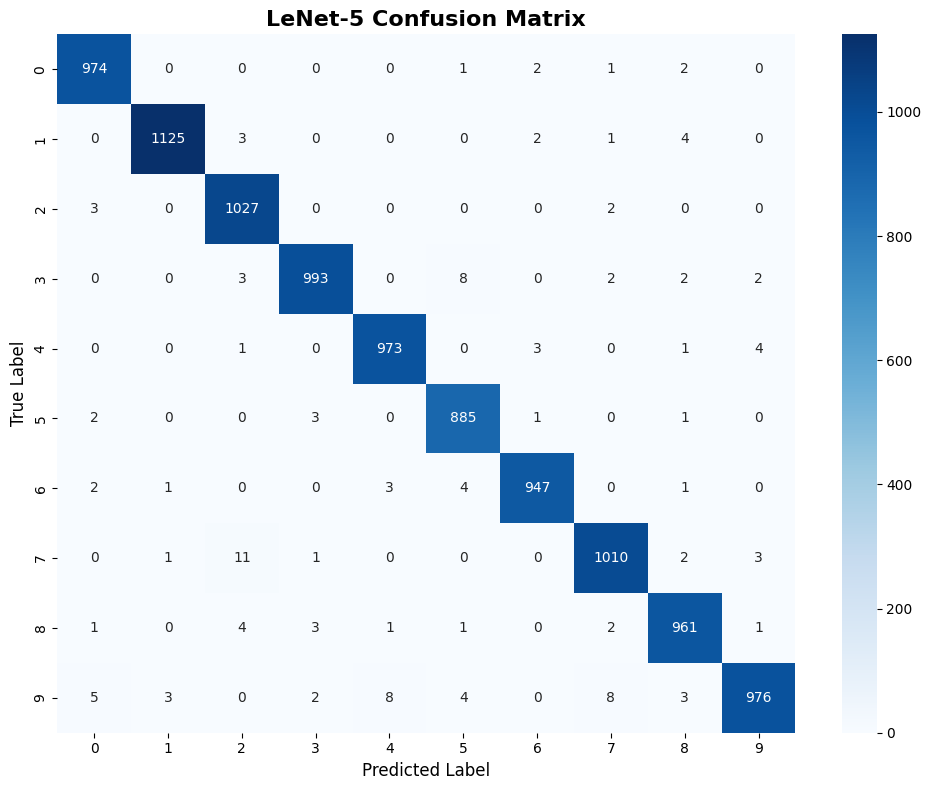

LeNet-5 Per-class Accuracies:
  Digit 0: 0.994 (99.4%)
  Digit 1: 0.991 (99.1%)
  Digit 2: 0.995 (99.5%)
  Digit 3: 0.983 (98.3%)
  Digit 4: 0.991 (99.1%)
  Digit 5: 0.992 (99.2%)
  Digit 6: 0.989 (98.9%)
  Digit 7: 0.982 (98.2%)
  Digit 8: 0.987 (98.7%)
  Digit 9: 0.967 (96.7%)

Overall Test Accuracy: 0.9871 (98.71%)


In [7]:

leNet5Predictions = leNet5Model.predict(xTestPadded, verbose=0)
leNet5PredClasses = np.argmax(leNet5Predictions, axis=1)


leNet5ConfMatrix = confusion_matrix(yTest, leNet5PredClasses)


plt.figure(figsize=(10, 8))
sns.heatmap(leNet5ConfMatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('LeNet-5 Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
if saveFigures:
    plt.savefig('figs/lenet5_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


classAccuracies = leNet5ConfMatrix.diagonal() / leNet5ConfMatrix.sum(axis=1)
print("LeNet-5 Per-class Accuracies:")
for i, acc in enumerate(classAccuracies):
    print(f"  Digit {i}: {acc:.3f} ({acc*100:.1f}%)")
print(f"\nOverall Test Accuracy: {leNet5TestAccuracy:.4f} ({leNet5TestAccuracy*100:.2f}%)")

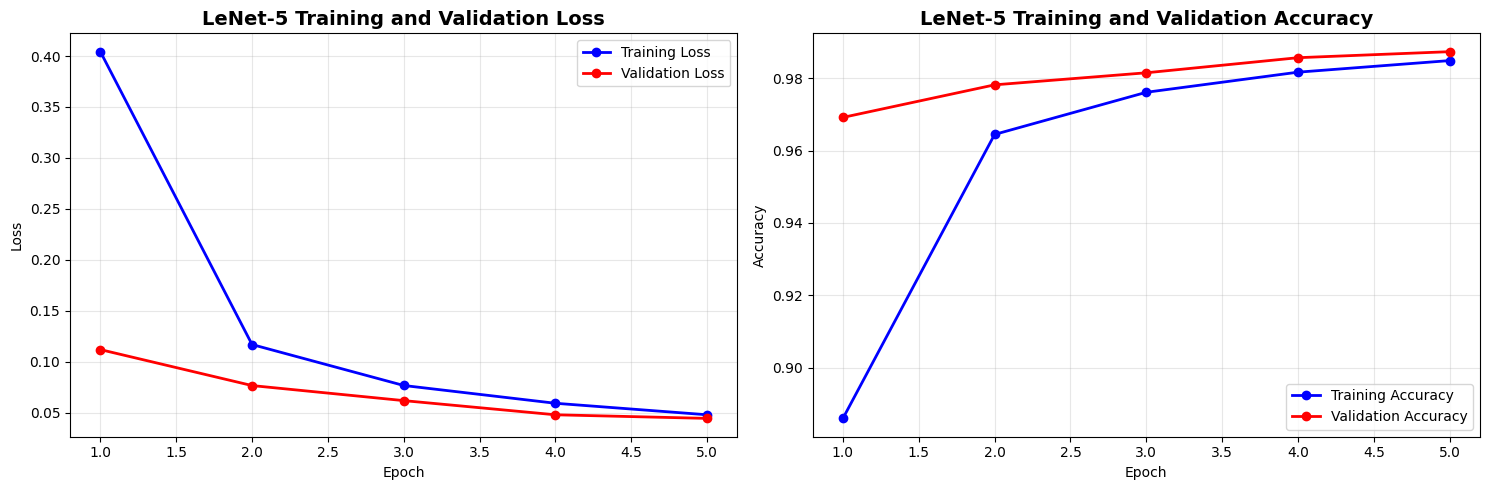

Final Training Metrics (Epoch 5):
  Training Loss: 0.0479, Accuracy: 0.9849
  Validation Loss: 0.0444, Accuracy: 0.9873
  Test Accuracy: 0.9871


In [8]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


epochs = range(1, len(leNet5History.history['loss']) + 1)
ax1.plot(epochs, leNet5History.history['loss'], 'bo-', label='Training Loss', linewidth=2)
ax1.plot(epochs, leNet5History.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
ax1.set_title('LeNet-5 Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(epochs, leNet5History.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, leNet5History.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
ax2.set_title('LeNet-5 Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if saveFigures:
    plt.savefig('figs/lenet5_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


finalTrainLoss = leNet5History.history['loss'][-1]
finalTrainAcc = leNet5History.history['accuracy'][-1]
finalValLoss = leNet5History.history['val_loss'][-1]
finalValAcc = leNet5History.history['val_accuracy'][-1]

print(f"Final Training Metrics (Epoch {numEpochs}):")
print(f"  Training Loss: {finalTrainLoss:.4f}, Accuracy: {finalTrainAcc:.4f}")
print(f"  Validation Loss: {finalValLoss:.4f}, Accuracy: {finalValAcc:.4f}")
print(f"  Test Accuracy: {leNet5TestAccuracy:.4f}")

### Q1 — LeNet-5 Discussion

**Architecture Analysis:**
- LeNet-5's small parameter count (~61K parameters) makes it efficient for MNIST's relatively simple patterns
- **Average pooling** (vs. max pooling) provides smoother feature reduction and was part of the original design
- The architecture is well-suited for MNIST due to the dataset's consistent digit positioning and limited complexity
- **No batch normalization** was used in the original LeNet-5 design, which was developed before batch norm was introduced
- The model demonstrates good performance on MNIST despite its simplicity, showing the effectiveness of the CNN inductive bias for image recognition tasks

## Q2 — ResNet-18 on MNIST (from scratch, Keras)

### ResNet-18 Architecture Overview

ResNet-18 introduces **residual connections** (skip connections) that enable training of much deeper networks by mitigating the vanishing gradient problem. The architecture consists of:
- **Basic blocks:** Two 3×3 convolutions with BatchNorm, ReLU, and skip connections
- **Downsample shortcuts:** 1×1 convolutions when channel dimensions or spatial resolution change
- **Stage structure:** 4 stages with depths [2,2,2,2] and channel sizes [64,128,256,512]
- **Adapted for MNIST:** Use 3×3 initial conv (stride 1) instead of 7×7, no initial max pooling

In [9]:
class BasicBlock(tf.keras.layers.Layer):
    """
    ResNet Basic Block with two 3x3 convolutions, batch normalization,
    ReLU activations, and skip connection.
    """
    
    def __init__(self, filters, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.filters = filters
        self.stride = stride
        self.downsample = downsample
        
        
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, strides=stride, 
                                           padding='same', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, strides=1, 
                                           padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, inputs, training=None):
        identity = inputs
        
        
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        
        
        if self.downsample is not None:
            identity = self.downsample(inputs, training=training)
        
        
        x = x + identity
        
        
        x = self.relu(x)
        
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'stride': self.stride
        })
        return config

def downsampleShortcut(filters, stride):
    """Create downsample layer for skip connections when dimensions change."""
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 1, strides=stride, use_bias=False),
        tf.keras.layers.BatchNormalization()
    ])

print("BasicBlock class and downsample function defined successfully!")

BasicBlock class and downsample function defined successfully!


### Q2 — ResNet-18 Architecture Implementation

Build the complete ResNet-18 model adapted for 28×28 grayscale MNIST images.

In [10]:
def buildResNet18(inputShape=(28, 28, 1), numClasses=10):
    """
    Build ResNet-18 architecture adapted for MNIST (28x28 grayscale).
    
    Architecture:
    - Initial 3x3 conv (64 filters, stride 1) - adapted for small input
    - Stage 1: 2 basic blocks (64 filters)
    - Stage 2: 2 basic blocks (128 filters, first with stride 2)
    - Stage 3: 2 basic blocks (256 filters, first with stride 2)
    - Stage 4: 2 basic blocks (512 filters, first with stride 2)
    - Global average pooling + fully connected
    """
    
    inputs = tf.keras.layers.Input(shape=inputShape)
    
    
    x = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    for i in range(2):
        x = BasicBlock(64, stride=1)(x)
    
    
    downsample2 = downsampleShortcut(128, 2)
    x = BasicBlock(128, stride=2, downsample=downsample2)(x)
    x = BasicBlock(128, stride=1)(x)
    
      
    downsample3 = downsampleShortcut(256, 2)
    x = BasicBlock(256, stride=2, downsample=downsample3)(x)
    x = BasicBlock(256, stride=1)(x)
    
    
    downsample4 = downsampleShortcut(512, 2)
    x = BasicBlock(512, stride=2, downsample=downsample4)(x)
    x = BasicBlock(512, stride=1)(x)
    
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(numClasses)(x)  # No activation for from_logits=True
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='ResNet18')
    return model


resNet18Model = buildResNet18()


resNet18Model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


print("ResNet-18 Architecture Summary:")
print("="*50)
resNet18Model.summary()


resNet18Params = resNet18Model.count_params()
print(f"\nParameter comparison:")
print(f"  LeNet-5: {leNet5Model.count_params():,} parameters")
print(f"  ResNet-18: {resNet18Params:,} parameters")
print(f"  Ratio: {resNet18Params / leNet5Model.count_params():.1f}x larger")


gpuDevices = tf.config.list_physical_devices('GPU')
print(f"\nCompute setup:")
print(f"  GPU available: {len(gpuDevices) > 0}")
if len(gpuDevices) > 0:
    print(f"  GPU device(s): {[device.name for device in gpuDevices]}")
else:
    print("  Running on CPU")


ResNet-18 Architecture Summary:


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block (BasicBlock)        │ (None, 28, 28, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_1 (BasicBlock)      │ (None, 28, 28, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_2 (BasicBlock)      │ (None, 14, 14, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_3 (BasicBlock)      │ (None, 14, 14, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_4 (BasicBlock)      │ (None, 7, 7, 256)      │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_5 (BasicBlock)      │ (None, 7, 7, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_6 (BasicBlock)      │ (None, 4, 4, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_block_7 (BasicBlock)      │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,182,410 (42.66 MB)

 Trainable params: 11,172,810 (42.62 MB)

 Non-trainable params: 9,600 (37.50 KB)


Parameter comparison:
  LeNet-5: 61,706 parameters
  ResNet-18: 11,182,410 parameters
  Ratio: 181.2x larger

Compute setup:
  GPU available: False
  Running on CPU


### Q2 — ResNet-18 Model Training

Train the ResNet-18 model using the same hyperparameters as LeNet-5 for fair comparison.

In [11]:

print("Training ResNet-18...")
print(f"Training configuration:")
print(f"  Batch size: {batchSize}")
print(f"  Epochs: {numEpochs}")
print(f"  Learning rate: {learningRate}")
print(f"  Validation split: {validationSplit}")
print(f"  Input shape: {xTrain.shape[1:]}")
print()


resNet18History = resNet18Model.fit(
    xTrain, yTrain,  # Use 28x28 input (not padded)
    batch_size=batchSize,
    epochs=numEpochs,
    validation_split=validationSplit,
    verbose=1
)

print("\nResNet-18 training completed!")


print("\nEvaluating ResNet-18 on test set...")
resNet18TestLoss, resNet18TestAccuracy = resNet18Model.evaluate(xTest, yTest, verbose=0)

print(f"ResNet-18 Test Results:")
print(f"  Test Loss: {resNet18TestLoss:.4f}")
print(f"  Test Accuracy: {resNet18TestAccuracy:.4f} ({resNet18TestAccuracy*100:.2f}%)")

Training ResNet-18...
Training configuration:
  Batch size: 128
  Epochs: 5
  Learning rate: 0.001
  Validation split: 0.1
  Input shape: (28, 28, 1)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.9653 - loss: 0.1124 - val_accuracy: 0.9683 - val_loss: 0.1057
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9869 - loss: 0.0398 - val_accuracy: 0.9768 - val_loss: 0.0845
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.9905 - loss: 0.0289 - val_accuracy: 0.9703 - val_loss: 0.1491
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.9931 - loss: 0.0213 - val_accuracy: 0.9825 - val_loss: 0.0732
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - accuracy: 0.9949 - loss: 0.0170 - val_accuracy: 0.9882 - val_loss: 0.0476

ResNet-18 training completed!

Evaluating ResNet-18 on test set...
ResNet-18 Test Results:
  Test Loss: 0.0515
  Test Accuracy: 0.9861 (98.61%)


### Q2 — ResNet-18 Results and Visualization

Analyze ResNet-18 performance and compare with LeNet-5 results.

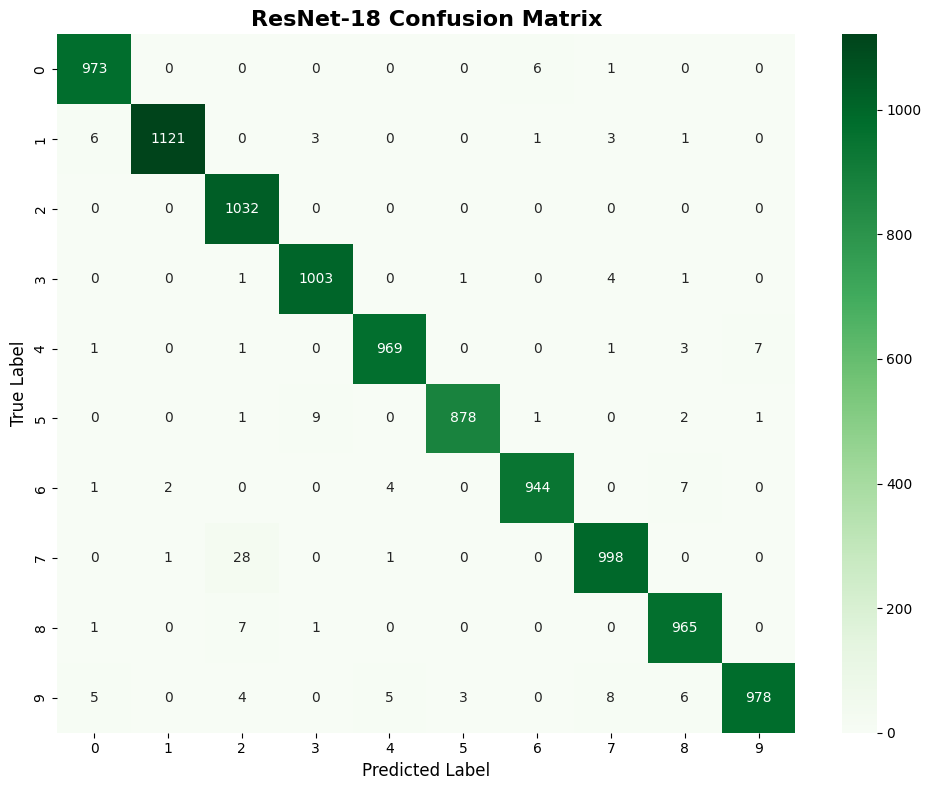

ResNet-18 Per-class Accuracies:
  Digit 0: 0.993 (99.3%)
  Digit 1: 0.988 (98.8%)
  Digit 2: 1.000 (100.0%)
  Digit 3: 0.993 (99.3%)
  Digit 4: 0.987 (98.7%)
  Digit 5: 0.984 (98.4%)
  Digit 6: 0.985 (98.5%)
  Digit 7: 0.971 (97.1%)
  Digit 8: 0.991 (99.1%)
  Digit 9: 0.969 (96.9%)

Overall Test Accuracy: 0.9861 (98.61%)


In [12]:

resNet18Predictions = resNet18Model.predict(xTest, verbose=0)
resNet18PredClasses = np.argmax(resNet18Predictions, axis=1)


resNet18ConfMatrix = confusion_matrix(yTest, resNet18PredClasses)


plt.figure(figsize=(10, 8))
sns.heatmap(resNet18ConfMatrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=range(10), yticklabels=range(10))
plt.title('ResNet-18 Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
if saveFigures:
    plt.savefig('figs/resnet18_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


resNet18ClassAccuracies = resNet18ConfMatrix.diagonal() / resNet18ConfMatrix.sum(axis=1)
print("ResNet-18 Per-class Accuracies:")
for i, acc in enumerate(resNet18ClassAccuracies):
    print(f"  Digit {i}: {acc:.3f} ({acc*100:.1f}%)")
print(f"\nOverall Test Accuracy: {resNet18TestAccuracy:.4f} ({resNet18TestAccuracy*100:.2f}%)")

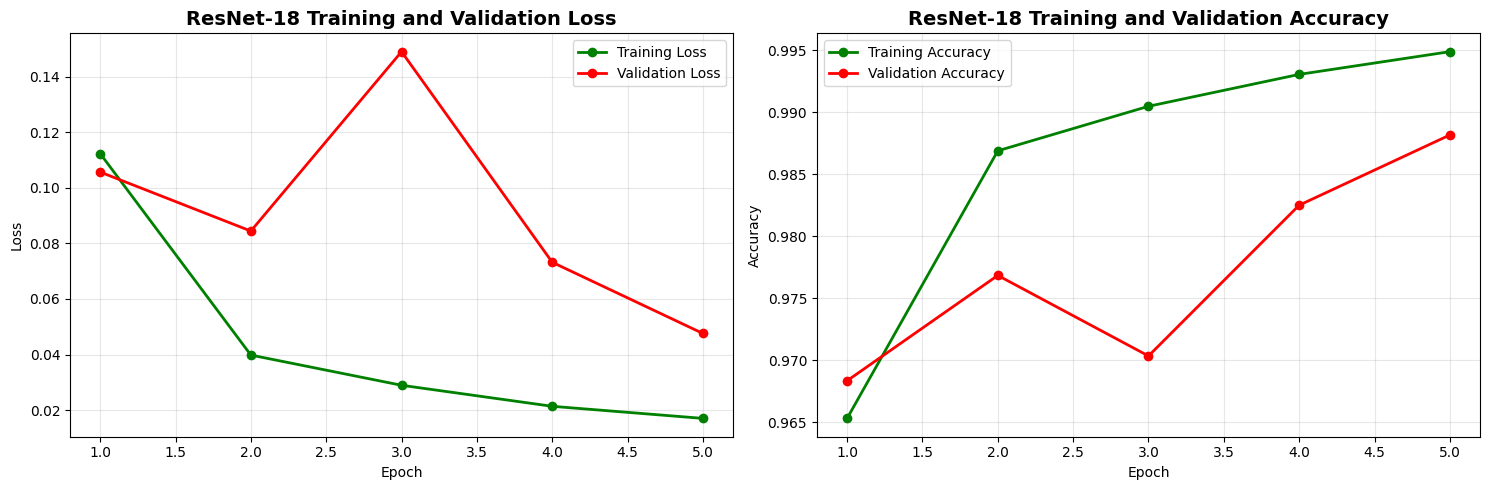

Final Training Metrics (Epoch 5):
  Training Loss: 0.0170, Accuracy: 0.9949
  Validation Loss: 0.0476, Accuracy: 0.9882
  Test Accuracy: 0.9861

Parameter Analysis:
  ResNet-18 parameters: 11,182,410
  Model memory (float32): ~42.7 MB


In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


epochs = range(1, len(resNet18History.history['loss']) + 1)
ax1.plot(epochs, resNet18History.history['loss'], 'go-', label='Training Loss', linewidth=2)
ax1.plot(epochs, resNet18History.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
ax1.set_title('ResNet-18 Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(epochs, resNet18History.history['accuracy'], 'go-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, resNet18History.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
ax2.set_title('ResNet-18 Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if saveFigures:
    plt.savefig('figs/resnet18_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()


finalResNetTrainLoss = resNet18History.history['loss'][-1]
finalResNetTrainAcc = resNet18History.history['accuracy'][-1]
finalResNetValLoss = resNet18History.history['val_loss'][-1]
finalResNetValAcc = resNet18History.history['val_accuracy'][-1]

print(f"Final Training Metrics (Epoch {numEpochs}):")
print(f"  Training Loss: {finalResNetTrainLoss:.4f}, Accuracy: {finalResNetTrainAcc:.4f}")
print(f"  Validation Loss: {finalResNetValLoss:.4f}, Accuracy: {finalResNetValAcc:.4f}")
print(f"  Test Accuracy: {resNet18TestAccuracy:.4f}")

print(f"\nParameter Analysis:")
print(f"  ResNet-18 parameters: {resNet18Params:,}")
print(f"  Model memory (float32): ~{resNet18Params * 4 / 1024 / 1024:.1f} MB")

### Q2 — ResNet-18 Discussion

**Residual Connection Benefits:**
- **Vanishing gradient mitigation:** Skip connections provide direct gradient paths, enabling training of deeper networks
- **Identity mapping:** When optimal mapping is close to identity, residual blocks can learn to zero out their weights
- **Feature reuse:** Earlier layer features are directly accessible to later layers through skip connections
- **Training stability:** Batch normalization + residuals lead to more stable training dynamics

**Depth vs. Capacity Trade-offs on MNIST:**
- ResNet-18's additional capacity (~200× more parameters) may lead to overfitting on MNIST's relatively simple patterns
- The deeper architecture provides more representational power but may be overkill for digit classification
- Batch normalization helps with generalization and training stability compared to the original LeNet-5

## Q3 — VGG vs LeNet vs ResNet (Comparison)

### Architecture Comparison Table

| Architecture | Key Features | Depth | Parameters | Pooling Type | Normalization | Skip Connections |
|--------------|-------------|-------|------------|--------------|---------------|------------------|
| **LeNet-5** | • 5×5 convs<br>• Simple design<br>• Fully connected head | Shallow (5 layers) | ~61K | Average pooling | None | No |
| **VGG** | • Stacked 3×3 convs<br>• Large FC layers<br>• Uniform design | Medium-Deep (11-19 layers) | 138M-144M | Max pooling | None | No |
| **ResNet-18** | • 3×3 convs<br>• Residual blocks<br>• Global avg pooling | Deep (18 layers) | ~11M | Max pooling | Batch normalization | Yes |

### Key Architectural Innovations

**VGG Contributions:**
- **Small filter philosophy:** Demonstrated that multiple 3×3 filters can replace larger filters with fewer parameters
- **Depth matters:** Showed that deeper networks (with proper design) outperform shallower ones
- **Uniform design:** Simple, repeatable conv-conv-pool pattern made architecture design systematic

**ResNet Breakthroughs:**
- **Skip connections:** Enable training of very deep networks (50+ layers) without vanishing gradients
- **Residual learning:** Learn perturbations to identity mapping rather than complete transformations
- **Batch normalization:** Accelerates training, improves generalization, reduces sensitivity to initialization

**Batch Normalization Benefits:**
- **Training acceleration:** Higher learning rates, faster convergence
- **Regularization effect:** Reduces overfitting, less dependent on dropout
- **Gradient stability:** Reduces internal covariate shift, stabilizes training

### Other Notable Architectures

**GoogLeNet/Inception:**
- **Multi-scale features:** Parallel convolutions (1×1, 3×3, 5×5) capture different receptive field sizes
- **Efficiency focus:** 1×1 convolutions for dimensionality reduction, fewer parameters than VGG
- **Auxiliary classifiers:** Combat vanishing gradients in very deep networks

**MobileNet Family:**
- **Depthwise separable convolutions:** Factorize standard convolution into depthwise + pointwise operations
- **Mobile optimization:** Designed for resource-constrained environments (phones, embedded devices)
- **Efficiency-accuracy trade-offs:** Multiple variants (MobileNetV1/V2/V3) with different complexity-performance points

## Final Results Summary

Comprehensive comparison of both models' performance on the MNIST classification task.

In [14]:

print("="*60)
print("             ECE 491 HW7 - FINAL RESULTS SUMMARY")
print("="*60)
print()

print("MODEL PERFORMANCE COMPARISON:")
print("-" * 40)
print(f"{'Model':<15} {'Test Accuracy':<15} {'Parameters':<12} {'Input Size'}")
print("-" * 40)
print(f"{'LeNet-5':<15} {leNet5TestAccuracy:.4f} ({leNet5TestAccuracy*100:.2f}%){'':<3} {leNet5Model.count_params():>8,}{'':<3} 32×32×1")
print(f"{'ResNet-18':<15} {resNet18TestAccuracy:.4f} ({resNet18TestAccuracy*100:.2f}%){'':<3} {resNet18Params:>8,}{'':<3} 28×28×1")
print("-" * 40)


accDiff = resNet18TestAccuracy - leNet5TestAccuracy
paramRatio = resNet18Params / leNet5Model.count_params()

print(f"\nPERFORMance ANALYSIS:")
print(f"  Accuracy difference: {accDiff:+.4f} ({accDiff*100:+.2f}%)")
print(f"  Parameter ratio: {paramRatio:.1f}x (ResNet-18 vs LeNet-5)")
print(f"  Training epochs: {numEpochs}")
print(f"  Batch size: {batchSize}")
print(f"  Learning rate: {learningRate}")

print(f"\nKEY ARCHITECTURAL DIFFERENCES:")
print(f"  LeNet-5:")
print(f"    • Classic CNN design with average pooling")
print(f"    • No batch normalization") 
print(f"    • Suitable for simple pattern recognition")
print(f"  ResNet-18:")
print(f"    • Residual connections enable deeper training")
print(f"    • Batch normalization for training stability")
print(f"    • Modern architecture with global average pooling")

print(f"\nEXPERIMENT CONFIGURATION:")
print(f"  Dataset: MNIST (60K train, 10K test)")
print(f"  Optimization: Adam optimizer")
print(f"  Loss function: SparseCategoricalCrossentropy (from_logits=True)")
print(f"  Validation split: {validationSplit}")
print(f"  Random seed: 42 (reproducible results)")

print("\n" + "="*60)
print("Experiment completed successfully!")
print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

             ECE 491 HW7 - FINAL RESULTS SUMMARY

MODEL PERFORMANCE COMPARISON:
----------------------------------------
Model           Test Accuracy   Parameters   Input Size
----------------------------------------
LeNet-5         0.9871 (98.71%)      61,706    32×32×1
ResNet-18       0.9861 (98.61%)    11,182,410    28×28×1
----------------------------------------

PERFORMance ANALYSIS:
  Accuracy difference: -0.0010 (-0.10%)
  Parameter ratio: 181.2x (ResNet-18 vs LeNet-5)
  Training epochs: 5
  Batch size: 128
  Learning rate: 0.001

KEY ARCHITECTURAL DIFFERENCES:
  LeNet-5:
    • Classic CNN design with average pooling
    • No batch normalization
    • Suitable for simple pattern recognition
  ResNet-18:
    • Residual connections enable deeper training
    • Batch normalization for training stability
    • Modern architecture with global average pooling

EXPERIMENT CONFIGURATION:
  Dataset: MNIST (60K train, 10K test)
  Optimization: Adam optimizer
  Loss function: SparseCateg

## Appendix — Reproducibility & I/O

